In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## change the path
import os
os.chdir('drive/MyDrive/Colab Notebooks/optimization_machine_learning_project/optimization_machine_learning_project')

In [ ]:
from src import *

In [ ]:
import sys

In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

import matplotlib.pyplot as plt

from networkx.classes.function import neighbors
from tqdm import tqdm

import pandas as pd

from os import listdir
from os.path import isfile, join

In [ ]:
plt.style.use('fivethirtyeight')
colors = ['#13EAC9', '#069AF3', '#FC5A50', '#15B01A', '#929581', '#808000', '#7E1E9C', '#029386']

In [ ]:
datasetMNIST = datasets.MNIST(root="./", download=True)

In [ ]:
# set device
if torch.cuda.is_available():
    device = 'cuda'
else:
    print("No GPU :(")
    device = 'cpu'

In [ ]:
# create file to save the trained model
current_path = os.getcwd()
result_path = join(current_path, 'different_topology_logs')

if not os.path.exists(result_path):
    os.makedirs(result_path)

# TOPOLOGY

Demonstrate the figures of different topologies

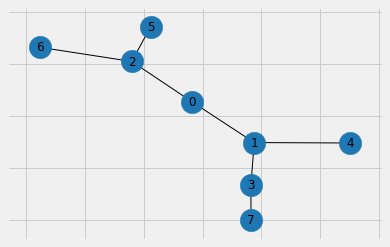

In [ ]:
s = BinaryTreeTopology(8)
g = s.to_networkx()
s.draw_graph(with_labels=True)

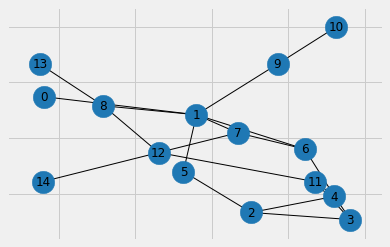

In [ ]:
s = SocialNetworkTopology()
g = s.to_networkx()
s.draw_graph(with_labels=True)

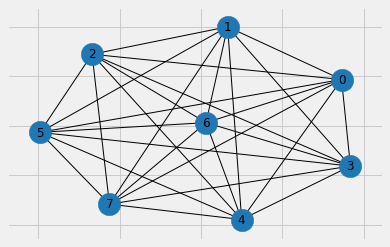

In [ ]:
s = FullConnectedTopology(8)
g = s.to_networkx()
s.draw_graph(with_labels=True)

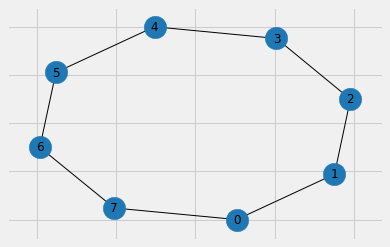

In [ ]:
s = ringTopology(8)
g = s.to_networkx()
s.draw_graph(with_labels=True)

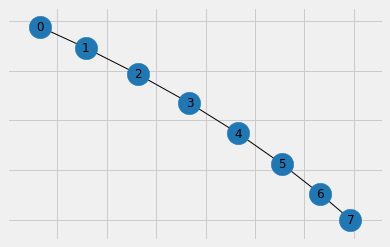

In [ ]:
s = ChainTopology(8)
g = s.to_networkx()
s.draw_graph(with_labels=True)

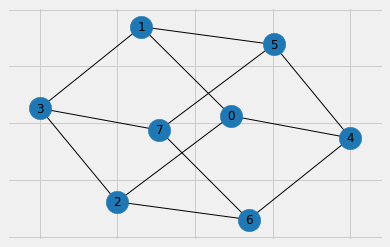

In [ ]:
s = TorusTopology(8, dimension='3d')
g = s.to_networkx()
s.draw_graph(with_labels=True)

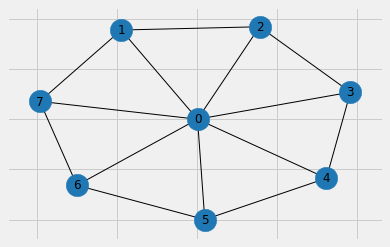

In [ ]:
s = WheelTopology(8)
g = s.to_networkx()
s.draw_graph(with_labels=True)

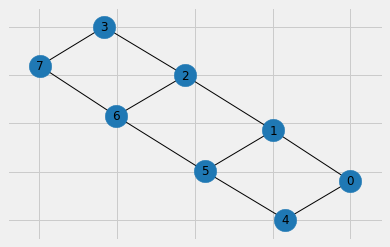

In [ ]:
s = LadderTopology(8)
g = s.to_networkx()
s.draw_graph(with_labels=True)

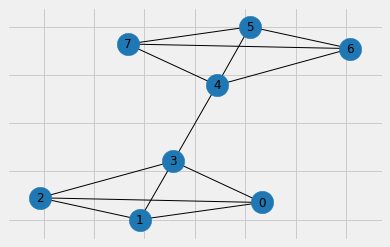

In [ ]:
s = BarbellTopology(8)
g = s.to_networkx()
s.draw_graph(with_labels=True)

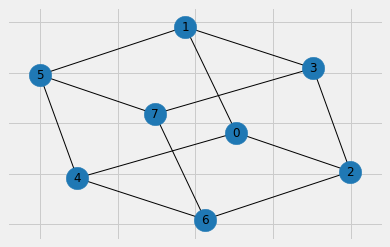

In [ ]:
s = HyperCubeTopology(8)
g = s.to_networkx()
s.draw_graph(with_labels=True)

# Load data and split


Split data into trainset, testset and validation set

In [ ]:
load = Loader()
mnist, mnistL = load.toArray(datasetMNIST)
# mnist, mnistL = (torch.tensor(mnist).float()[:30000], torch.tensor(mnistL))[:30000]
mnist, mnistL = (torch.tensor(mnist).float(), torch.tensor(mnistL))
print('shape of dataset from MNIST {}'.format(mnist.shape))

shape of dataset from MNIST torch.Size([60000, 28, 28])


In [ ]:
trainset, trainL= mnist[:-20000], mnistL[:-20000]
valset, valL   = mnist[-20000:-10000], mnistL[-20000:-10000]
testset, testL  = mnist[-10000:], mnistL[-10000:]

In [ ]:
trainset.shape

torch.Size([40000, 28, 28])

Check label are balanced in train/val/test

Text(0.5, 1.0, 'test label distribution')

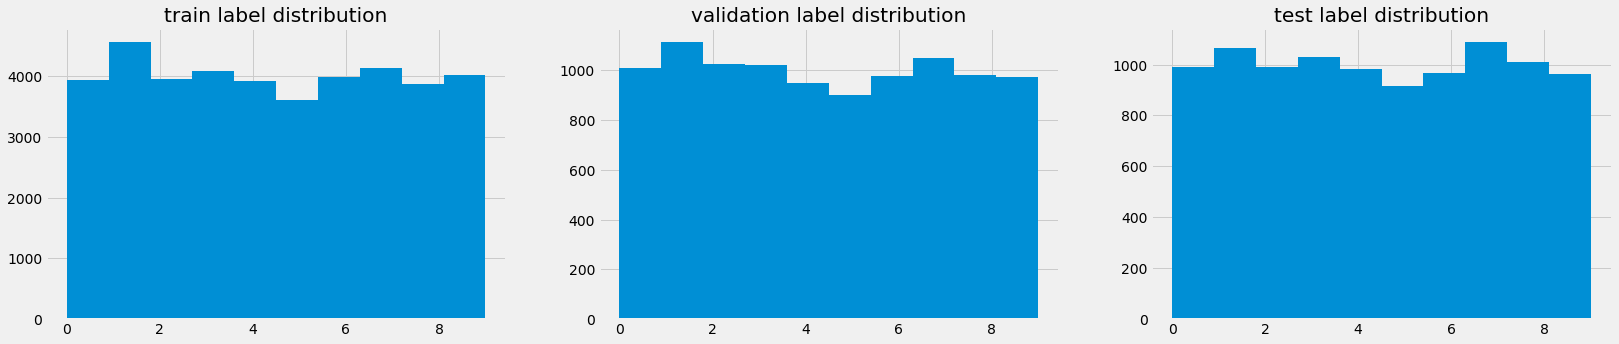

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(25,5))
ax[0].hist(trainL.flatten())
ax[1].hist(valL.flatten())
ax[2].hist(testL.flatten())
ax[0].set_title("train label distribution")
ax[1].set_title("validation label distribution")
ax[2].set_title("test label distribution")

In [ ]:
def train(nodedata, nodemodel, nodeoptimizer, loss_fn, epoch, device, verbose=True):
    running_loss = 0.0
    for i in range(len(nodedata[0])):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = nodedata[0][i].to(device), nodedata[1][i].to(device)

        # zero the parameter gradients
        nodeoptimizer.zero_grad()

        # forward + backward + optimize
        outputs = nodemodel(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()
        nodeoptimizer.step()

        # print statistics
        running_loss += loss.item()
        if verbose:
            if i % 10 == 9:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0

# defining mixing matrix with self loops
def mixing_matrix(graph, loop=False):
    x = nx.to_numpy_matrix(graph)
    # with self loops
    if loop:
        x = x + np.eye(x.shape[0])
        
    for i in range(x.shape[0]):
        n_neighbors = np.count_nonzero(x[i, :])
        mixing_matrix = 1 / n_neighbors
        x[i, np.array(x[i, :], dtype=bool)[0]] = mixing_matrix
        #x[np.array(x[i, :], dtype=bool)[0], i] = mixing_matrix
    
    return x

# record the loss states for each node
def subopt(nodedata, nodemodel, loss_fn, device):
    nodemodel.eval()
    total, total_loss, correct = 0, 0, 0
    for i in range(len(nodedata[0])):
        inputs, labels = nodedata[0][i].to(device), nodedata[1][i].to(device)

        with torch.no_grad():
            outputs = nodemodel(inputs)
            loss = loss_fn(outputs, labels)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        total_loss += loss.item() 
    
    return total_loss / total, correct / total

# Convergence of decentralized SGD

In [ ]:
# partition data into K for batch training
K = 8 # number of nodes
nodesData = []
batchSize = 100
prev = 0
totalNbofImg = trainset.shape[0]

for i in range(0, totalNbofImg+1, totalNbofImg//K):
    if i == 0: continue
    tmpX = trainset[prev:i].reshape(-1, batchSize, 1, 28,28)
    tmpy = trainL[prev:i].reshape(-1, batchSize)
    nodesData.append((tmpX,tmpy))
    prev = i

# (images and labels for second dim of nodesData)
print(nodesData[0][0].shape) #(nb of batches, nb of image in one batch, img dimesion)
print(nodesData[0][1].shape)

nodesValidation = (valset.reshape(-1, valset.shape[0], 1, 28, 28), valL.reshape(-1,valL.shape[0]))
nodesTest       = (testset.reshape(-1, testset.shape[0], 1, 28, 28), testL.reshape(-1,testL.shape[0]))

torch.Size([50, 100, 1, 28, 28])
torch.Size([50, 100])


In [ ]:
def computeDecentralize(nodesData, topology, K, device, max_epoch=10, validation=None):
    graph = topology.to_networkx()
    W = nx.adjacency_matrix(graph)
    # topology.draw_graph()

    W = mixing_matrix(graph, loop=False)

    # we define model and optimizers for each nodes
    # reset the models and optimizers
    models     = []
    optimizers = []
    losses     = []

    for i in range(K):
        model     = CNN().to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
        loss_fn   = nn.CrossEntropyLoss()

        models.append(model)
        optimizers.append(optimizer)
        losses.append(loss_fn)

    train_stats = {str(node):[] for node in graph.nodes()}
    val_stats   = {str(node):[] for node in graph.nodes()}
    cDists      = []

    for epoch in tqdm(range(max_epoch)):
        # we train separately the nodes with their respective data 
        # we update implicitely models and optimizers
        for node_idx in graph.nodes():

            train(nodesData[node_idx], models[node_idx], optimizers[node_idx], losses[node_idx], epoch, device, verbose=False)

        # we share the parameters weights among the neighbours
        for node_idx in graph.nodes():
            neighbors = topology.get_neighbors(node_idx)

            # without self loops
            ret = zeroParam(getParams(models[node_idx]))

            # with self loops
    #         ret = getParams(models[node_idx])
    #         ret = prod(ret, W[node_idx, node_idx])

            for p in neighbors:
                p_params = getParams(models[p])
                tmp = prod(p_params, W[node_idx, p])
                ret = addition(ret, tmp)

            # copying the parameters to inplace operation for each nodes
            with torch.no_grad():
                for idx, param in enumerate(models[node_idx].parameters()):
                    param.copy_(ret[idx])


            loss, acc = subopt(nodesData[node_idx], models[node_idx], loss_fn, device)
            curTrainDir    = {'Epoch': epoch + 1, 'loss': loss, 'acc': acc}
            train_stats[str(node_idx)].append(curTrainDir)
            
            if not validation is None:
                lossVal, accVal = subopt(validation, models[node_idx], loss_fn, device)
                curValDir       = {'Epoch': epoch + 1, 'loss': lossVal, 'acc': accVal}
                val_stats[str(node_idx)].append(curValDir)                

        cDist  = consensusDistance(models)
        cDists.append(cDist)
    
    resultdfTrain   = getLogs(train_stats)
    resultdfVal    = None
    if not validation is None:
        resultdfVal     = getLogs(val_stats)

    return resultdfTrain, resultdfVal, cDists, models

In [ ]:
def test(nodesTest, topology, models, device):
    graph = topology.to_networkx() # convert topology to networkx graph
    loss_fn   = nn.CrossEntropyLoss()
    test_stats   = {str(node):[] for node in graph.nodes()} # dictionary to record states of test

    for node_idx in graph.nodes():
        neighbors = topology.get_neighbors(node_idx)

        lossTest, accTest = subopt(nodesTest, models[node_idx], loss_fn, device)
        curTestDir       = {'loss': lossTest, 'acc': accTest}
        test_stats[str(node_idx)].append(curTestDir)
        
    resultdfTest = getLogs(test_stats)
    return resultdfTest

## Homogenous data distribution for various standard topology

Decentralized learning with Torus 3d Topology


100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Test accuracy of Torus 3d Topology: 0.9823
Decentralized learning with Ring Topology


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Test accuracy of Ring Topology: 0.9818
Decentralized learning with Fully connected Topology


100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Test accuracy of Fully connected Topology: 0.9836
Decentralized learning with Chain Topology


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy of Chain Topology: 0.9815
Decentralized learning with Binary Tree Topology


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Test accuracy of Binary Tree Topology: 0.9834
Decentralized learning with Wheel Topology


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy of Wheel Topology: 0.9821
Decentralized learning with Ladder Topology


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Test accuracy of Ladder Topology: 0.9809
Decentralized learning with Barbell Topology


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Test accuracy of Barbell Topology: 0.9831


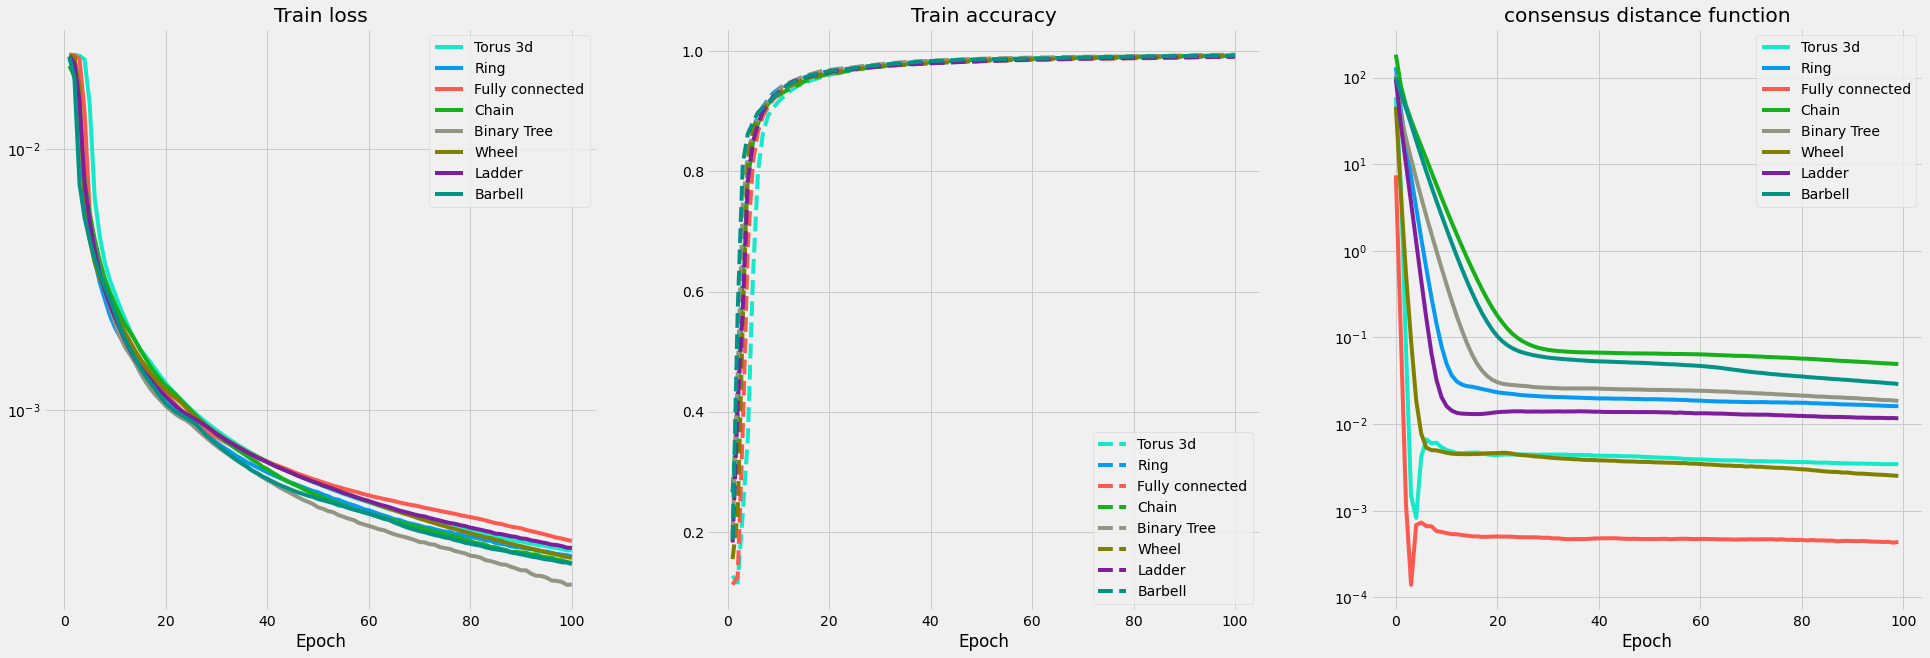

In [ ]:
## Number of nodes
K = 8

## define plots
fig,ax = plt.subplots(1,3, figsize=(30,10))
ax[0].set_title('Train loss')
ax[1].set_title('Train accuracy')
ax[2].set_title('consensus distance function')

T = ['Torus 3d', 'Ring', 'Fully connected', 'Chain', 'Binary Tree', 'Wheel', 'Ladder', 'Barbell']
topologies = [TorusTopology, ringTopology, FullConnectedTopology, ChainTopology, BinaryTreeTopology, WheelTopology, LadderTopology, BarbellTopology]
valState = {t:None for t in T}

for c, name, topology in zip(colors, T, topologies):
    print('Decentralized learning with {} Topology'.format(name))
    if name == 'Social Net':
        t = topology()
        resultdf, resultVal, cDists, models = computeDecentralize(nodesData, t, K, device, max_epoch=100, validation=nodesValidation)
    elif 'Torus' in name:
        t = topology(K, dimension=name.split()[-1])
        resultdf, resultVal, cDists, models = computeDecentralize(nodesData, t, K, device, max_epoch=100, validation=nodesValidation)
    else:
        t = topology(K)
        resultdf, resultVal, cDists, models = computeDecentralize(nodesData, t, K, device, max_epoch=100, validation=nodesValidation)
    
    ax[0].plot(resultdf.groupby('Epoch').mean()['loss'], label=name, color=c)
    ax[0].set_yscale('log')
    ax[1].plot(resultdf.groupby('Epoch').mean()['acc'], linestyle='dashed', label=name, color=c)
    ax[2].plot(cDists, label=name, color=c)
    ax[2].set_yscale('log')
    valState[name] = resultVal

    resultdfTest = test(nodesTest, t, models, device)
    testacc = resultdfTest['acc'].mean()
    print('Test accuracy of {} Topology: {:.4f}'.format(name, testacc))

for i in range(3):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

Decentralized learning with Torus 3d Topology
Decentralized learning with Ring Topology
Decentralized learning with Fully connected Topology
Decentralized learning with Chain Topology
Decentralized learning with Binary Tree Topology
Decentralized learning with Wheel Topology
Decentralized learning with Ladder Topology
Decentralized learning with Barbell Topology


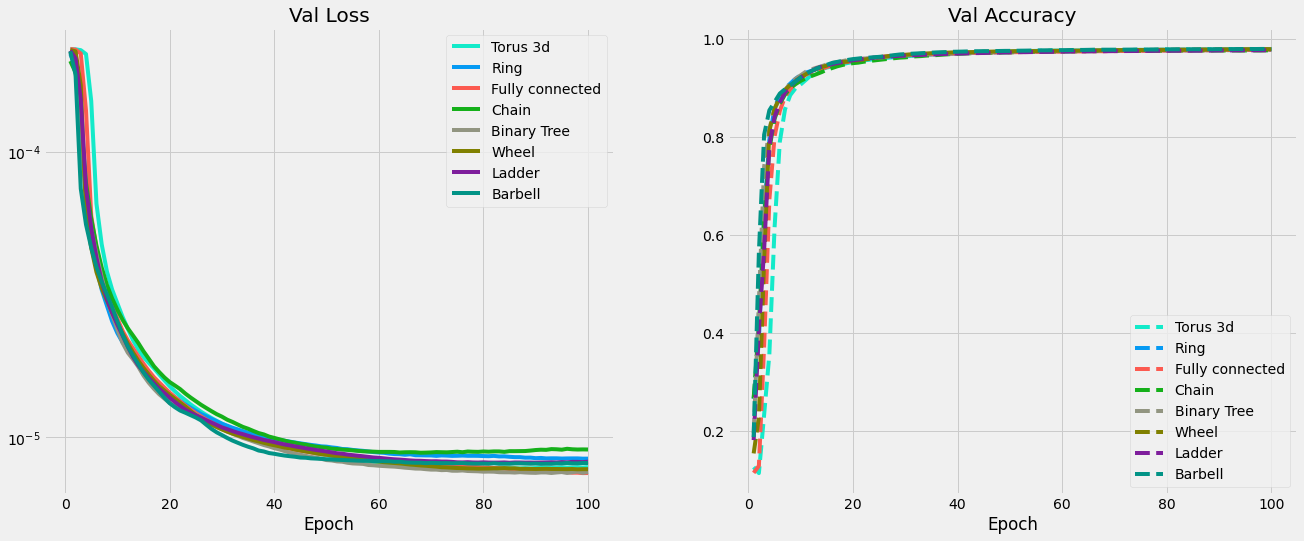

In [ ]:
## define plots
fig,ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set_title('Val Loss')
ax[1].set_title('Val Accuracy')

for c, name, topology in zip(colors, T, topologies):
    print('Decentralized learning with {} Topology'.format(name))
    ax[0].plot(valState[name].groupby('Epoch').mean()['loss'], label=name, color=c)
    ax[0].set_yscale('log')
    ax[1].plot(valState[name].groupby('Epoch').mean()['acc'], linestyle='dashed', label=name, color=c)


for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

**Ten runs**

Decentralized learning with Torus 3d Topology
Run 0!


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Test accuracy: 0.9827
Run 1!


100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Test accuracy: 0.9833
Run 2!


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Test accuracy: 0.9807
Run 3!


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy: 0.9844
Run 4!


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Test accuracy: 0.9828
Run 5!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9835
Run 6!


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Test accuracy: 0.9842
Run 7!


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy: 0.9829
Run 8!


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Test accuracy: 0.9835
Run 9!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9826
Test accuracy of Torus 3d Topology after 10 runs: mean 0.9831  std 0.0010 

Decentralized learning with Ring Topology
Run 0!


100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Test accuracy: 0.9828
Run 1!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9834
Run 2!


100%|██████████| 100/100 [02:31<00:00,  1.52s/it]


Test accuracy: 0.9807
Run 3!


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Test accuracy: 0.9837
Run 4!


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Test accuracy: 0.9822
Run 5!


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Test accuracy: 0.9821
Run 6!


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy: 0.9833
Run 7!


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy: 0.9842
Run 8!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9831
Run 9!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9818
Test accuracy of Ring Topology after 10 runs: mean 0.9827  std 0.0010 

Decentralized learning with Fully connected Topology
Run 0!


100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Test accuracy: 0.9831
Run 1!


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Test accuracy: 0.9838
Run 2!


100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Test accuracy: 0.9818
Run 3!


100%|██████████| 100/100 [02:40<00:00,  1.61s/it]


Test accuracy: 0.9856
Run 4!


100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


Test accuracy: 0.9828
Run 5!


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Test accuracy: 0.9834
Run 6!


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Test accuracy: 0.9833
Run 7!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9832
Run 8!


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Test accuracy: 0.9830
Run 9!


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Test accuracy: 0.9830
Test accuracy of Fully connected Topology after 10 runs: mean 0.9833  std 0.0009 

Decentralized learning with Chain Topology
Run 0!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9815
Run 1!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9837
Run 2!


100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Test accuracy: 0.9821
Run 3!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9838
Run 4!


100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


Test accuracy: 0.9818
Run 5!


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy: 0.9821
Run 6!


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Test accuracy: 0.9825
Run 7!


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy: 0.9843
Run 8!


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Test accuracy: 0.9819
Run 9!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9826
Test accuracy of Chain Topology after 10 runs: mean 0.9826  std 0.0009 

Decentralized learning with Binary Tree Topology
Run 0!


100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


Test accuracy: 0.9816
Run 1!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9836
Run 2!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9818
Run 3!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9843
Run 4!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9833
Run 5!


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Test accuracy: 0.9822
Run 6!


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Test accuracy: 0.9839
Run 7!


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Test accuracy: 0.9839
Run 8!


100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


Test accuracy: 0.9844
Run 9!


100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


Test accuracy: 0.9839
Test accuracy of Binary Tree Topology after 10 runs: mean 0.9833  std 0.0010 

Decentralized learning with Wheel Topology
Run 0!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9827
Run 1!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9834
Run 2!


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Test accuracy: 0.9814
Run 3!


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Test accuracy: 0.9837
Run 4!


100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


Test accuracy: 0.9822
Run 5!


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Test accuracy: 0.9834
Run 6!


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Test accuracy: 0.9848
Run 7!


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Test accuracy: 0.9834
Run 8!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9838
Run 9!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9840
Test accuracy of Wheel Topology after 10 runs: mean 0.9833  std 0.0009 

Decentralized learning with Ladder Topology
Run 0!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9833
Run 1!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9828
Run 2!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9818
Run 3!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9836
Run 4!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9825
Run 5!


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]


Test accuracy: 0.9836
Run 6!


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy: 0.9846
Run 7!


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Test accuracy: 0.9832
Run 8!


100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


Test accuracy: 0.9827
Run 9!


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Test accuracy: 0.9835
Test accuracy of Ladder Topology after 10 runs: mean 0.9832  std 0.0007 

Decentralized learning with Barbell Topology
Run 0!


100%|██████████| 100/100 [02:25<00:00,  1.45s/it]


Test accuracy: 0.9832
Run 1!


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Test accuracy: 0.9829
Run 2!


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Test accuracy: 0.9828
Run 3!


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


Test accuracy: 0.9839
Run 4!


100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


Test accuracy: 0.9827
Run 5!


100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


Test accuracy: 0.9823
Run 6!


100%|██████████| 100/100 [02:27<00:00,  1.48s/it]


Test accuracy: 0.9827
Run 7!


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]


Test accuracy: 0.9833
Run 8!


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy: 0.9827
Run 9!


100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Test accuracy: 0.9823
Test accuracy of Barbell Topology after 10 runs: mean 0.9829  std 0.0005 



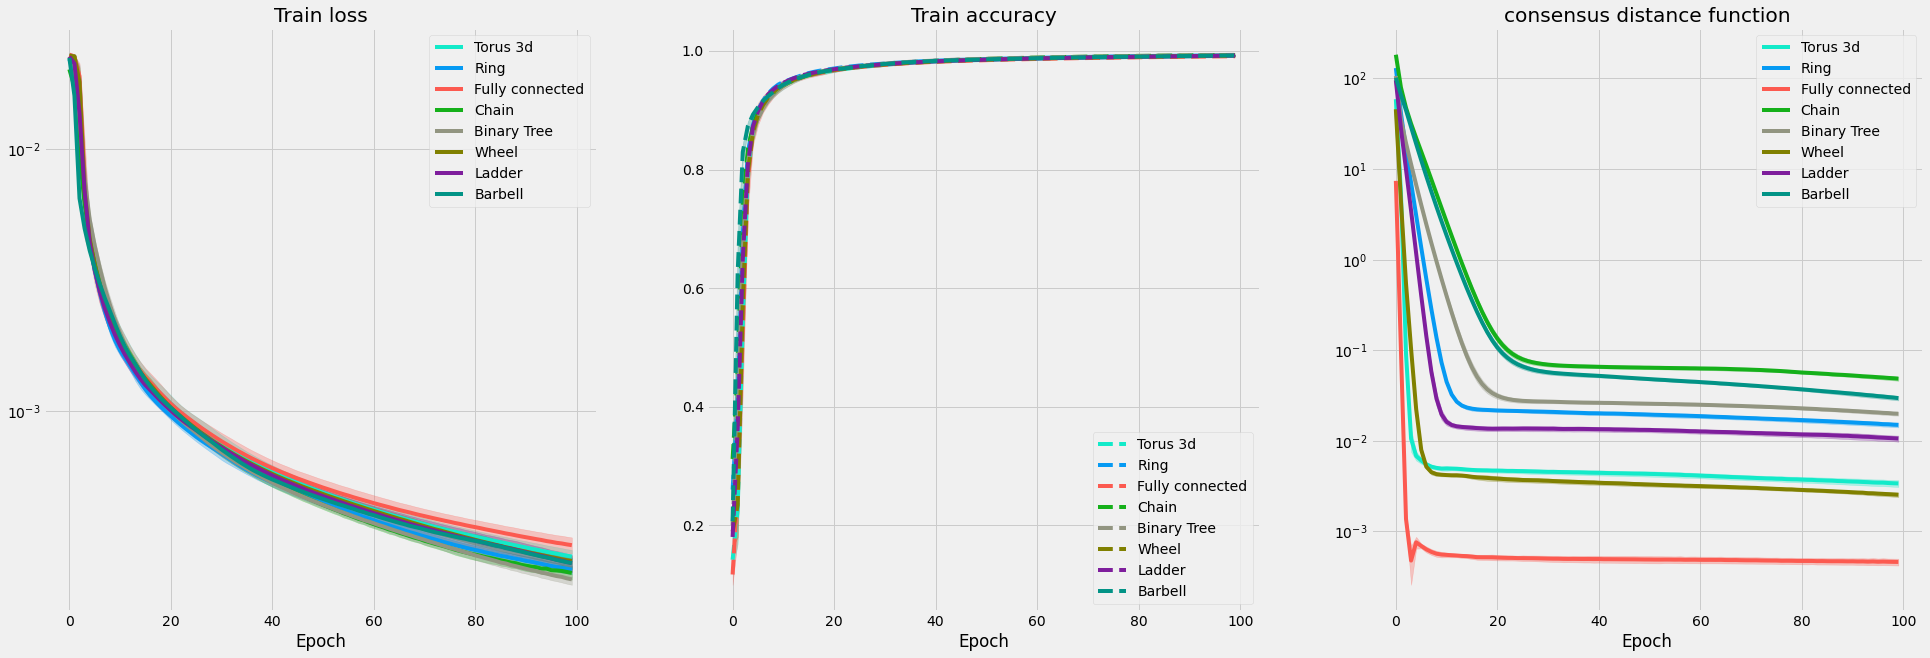

In [ ]:
## Number of epochs
maxEpoch = 100

## Number of nodes
K = 8

## Total number of runs
totalRuns = 10

## define plots
fig,ax = plt.subplots(1,3, figsize=(30,10))
ax[0].set_title('Train loss')
ax[1].set_title('Train accuracy')
ax[2].set_title('consensus distance function')

T = ['Torus 3d', 'Ring', 'Fully connected', 'Chain', 'Binary Tree', 'Wheel', 'Ladder', 'Barbell']
topologies = [TorusTopology, ringTopology, FullConnectedTopology, ChainTopology, BinaryTreeTopology, WheelTopology, LadderTopology, BarbellTopology]
states = {t:None for t in T}

for c, name, topology in zip(colors, T, topologies):
    losses = []
    testaccList = []
    acc = []
    valloss = []
    valacc = []
    cDistsList = []
    print('Decentralized learning with {} Topology'.format(name))
    for run in range(totalRuns):
        # set random seed
        torch.manual_seed(run)
        torch.cuda.manual_seed(run) # set random seed of cuda
        torch.cuda.manual_seed_all(run) # set random seed of multi-GPU
        np.random.seed(run)

        print('Run {}!'.format(run))

        if name == 'Social Net':
            t = topology()
            resultdf, resultVal, cDists, models = computeDecentralize(nodesData, t, K, device, max_epoch=maxEpoch, validation=nodesValidation)
        elif 'Torus' in name:
            t = topology(K, dimension=name.split()[-1])
            resultdf, resultVal, cDists, models = computeDecentralize(nodesData, t, K, device, max_epoch=100, validation=nodesValidation)            
        else:
            t = topology(K)
            resultdf, resultVal, cDists, models = computeDecentralize(nodesData, t, K, device, max_epoch=maxEpoch, validation=nodesValidation)
        losses.append(resultdf.groupby('Epoch').mean()['loss'])
        acc.append(resultdf.groupby('Epoch').mean()['acc'])
        cDistsList.append(cDists)

        valloss.append(resultVal.groupby('Epoch').mean()['loss'])
        valacc.append(resultVal.groupby('Epoch').mean()['acc'])
        
        resultdfTest = test(nodesTest, t, models, device)
        testacc = resultdfTest['acc'].mean()
        testaccList.append(testacc)
        print('Test accuracy: {:.4f}'.format(testacc))

    losses, acc, testaccList, cDistsList = np.array(losses), np.array(acc), np.array(testaccList), np.array(cDistsList)
    states[name] = {'trainloss': losses, 'trainacc': acc, 'testacc': testaccList, 'valloss': np.array(valloss), 'valacc': np.array(valacc)}
    ## calclate the mean and variance
    ax[0].plot(losses.mean(axis=0), label=name, color=c)
    ax[0].fill_between(np.arange(maxEpoch), losses.mean(axis=0) - np.std(losses, axis=0), losses.mean(axis=0) + np.std(losses, axis=0), alpha=0.3, color=c)
    ax[0].set_yscale('log')

    ax[1].plot(acc.mean(axis=0), linestyle='dashed', label=name, color=c)
    ax[1].fill_between(np.arange(maxEpoch), acc.mean(axis=0) - np.std(acc, axis=0), acc.mean(axis=0) + np.std(acc, axis=0), alpha=0.3, color=c)

    ax[2].plot(cDistsList.mean(axis=0), label=name, color=c)
    ax[2].fill_between(np.arange(maxEpoch), cDistsList.mean(axis=0) - np.std(cDistsList, axis=0), cDistsList.mean(axis=0) + np.std(cDistsList, axis=0), alpha=0.3, color=c)
    ax[2].set_yscale('log')

    print('Test accuracy of {} Topology after 10 runs: mean {:.4f}  std {:.4f} \n'.format(name, testaccList.mean(), np.std(testaccList, axis=0)))

for i in range(3):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

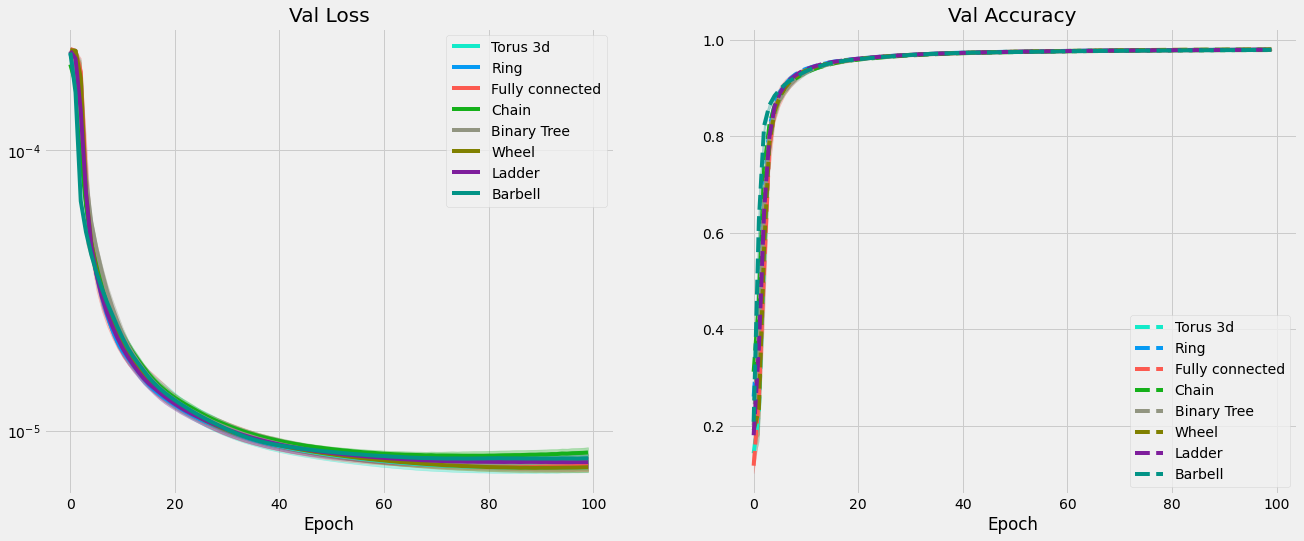

In [ ]:
## define plots
fig,ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set_title('Val Loss')
ax[1].set_title('Val Accuracy')

for c, name, topology in zip(colors, T, topologies):
    losses, acc = states[name]['valloss'], states[name]['valacc']
    ## calclate the mean and variance
    ax[0].plot(losses.mean(axis=0), label=name, color=c)
    ax[0].fill_between(np.arange(maxEpoch), losses.mean(axis=0) - np.std(losses, axis=0), losses.mean(axis=0) + np.std(losses, axis=0), alpha=0.3, color=c)
    ax[0].set_yscale('log')

    ax[1].plot(acc.mean(axis=0), linestyle='dashed', label=name, color=c)
    ax[1].fill_between(np.arange(maxEpoch), acc.mean(axis=0) - np.std(acc, axis=0), acc.mean(axis=0) + np.std(acc, axis=0), alpha=0.3, color=c)

for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

**Save results**

In [ ]:
with open(join(result_path, 'iid_ten_runs.pkl'),'wb') as f:
    pickle.dump(states, f)

## Heterogeneous data distribution for various standard topology


In [ ]:
# source: https://github.com/AshwinRJ/Federated-Learning-PyTorch/blob/master/src/sampling.py
def mnist_noniid(dataset, label, num_users, num_shards=20, num_imgs=2000, label_skew=2):
    """
    Sample non-I.I.D client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return:
    """
    # 60,000 training imgs -->  200 imgs/shard X 300 shards
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([]) for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    labels = label.clone().numpy()

    # sort labels
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign 2 shards/client
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, label_skew, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

IID label

(array([479., 563., 488., 493., 535., 434., 501., 550., 462., 495.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

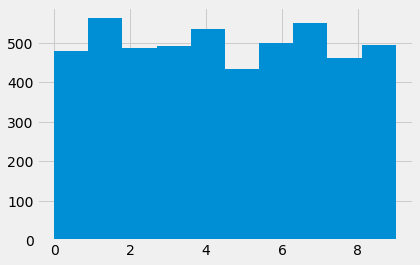

In [ ]:
plt.hist(nodesData[0][1].flatten())

NonIID label

In [ ]:
K = 8 # number of nodes
nodesNoneIIDData = []
batchSize = 100

np.random.seed(10)
indexIID = mnist_noniid(trainset, trainL, K)

for i in range(K):
    tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
    tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
    nodesNoneIIDData.append((tmpX,tmpy))


print(nodesNoneIIDData[0][0].shape)
print(nodesNoneIIDData[0][1].shape)

torch.Size([40, 100, 1, 28, 28])
torch.Size([40, 100])


(array([2000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

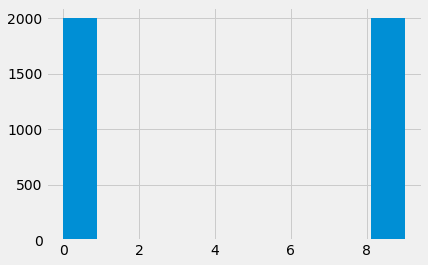

In [ ]:
plt.hist(nodesNoneIIDData[1][1].flatten())

tensor(6)


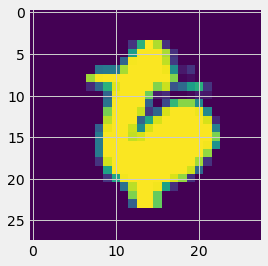

In [ ]:
plt.imshow(nodesNoneIIDData[2][0][1][0][0])
print(nodesNoneIIDData[2][1][1][0])

### Two labels

**One run**

Decentralized learning with Torus 3d Topology


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy of Torus 3d Topology: 0.7187
Decentralized learning with Ring Topology


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy of Ring Topology: 0.7288
Decentralized learning with Fully connected Topology


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Test accuracy of Fully connected Topology: 0.8462
Decentralized learning with Chain Topology


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy of Chain Topology: 0.6577
Decentralized learning with Binary Tree Topology


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy of Binary Tree Topology: 0.7438
Decentralized learning with Wheel Topology


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy of Wheel Topology: 0.1023
Decentralized learning with Ladder Topology


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy of Ladder Topology: 0.7079
Decentralized learning with Barbell Topology


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy of Barbell Topology: 0.8123


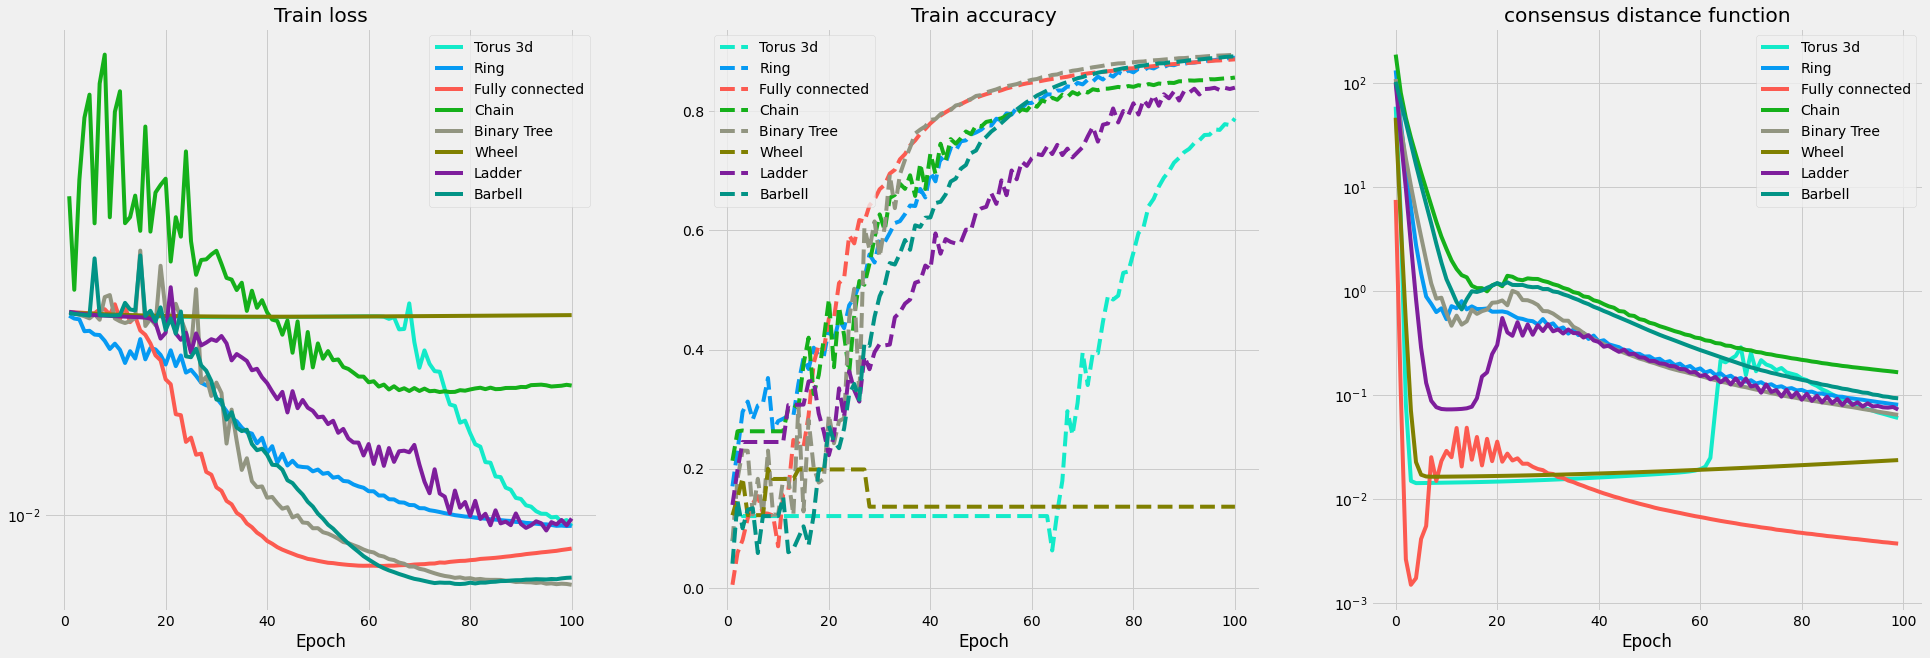

In [ ]:
## Number of nodes
K = 8

## define plots
fig,ax = plt.subplots(1,3, figsize=(30,10))
ax[0].set_title('Train loss')
ax[1].set_title('Train accuracy')
ax[2].set_title('consensus distance function')

T = ['Torus 3d', 'Ring', 'Fully connected', 'Chain', 'Binary Tree', 'Wheel', 'Ladder', 'Barbell']
topologies = [TorusTopology, ringTopology, FullConnectedTopology, ChainTopology, BinaryTreeTopology, WheelTopology, LadderTopology, BarbellTopology]
valState = {t:None for t in T}

for c, name, topology in zip(colors, T, topologies):
    print('Decentralized learning with {} Topology'.format(name))
    if name == 'Social Net':
        t = topology()
        resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=100, validation=nodesValidation)
    elif 'Torus' in name:
        t = topology(K, dimension=name.split()[-1])
        resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=100, validation=nodesValidation)
    else:
        t = topology(K)
        resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=100, validation=nodesValidation)
    
    ax[0].plot(resultdf.groupby('Epoch').mean()['loss'], label=name, color=c)
    ax[0].set_yscale('log')
    ax[1].plot(resultdf.groupby('Epoch').mean()['acc'], linestyle='dashed', label=name, color=c)
    ax[2].plot(cDists, label=name, color=c)
    ax[2].set_yscale('log')
    valState[name] = resultVal

    resultdfTest = test(nodesTest, t, models, device)
    testacc = resultdfTest['acc'].mean()
    print('Test accuracy of {} Topology: {:.4f}'.format(name, testacc))

for i in range(3):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

Decentralized learning with Torus 3d Topology
Decentralized learning with Ring Topology
Decentralized learning with Fully connected Topology
Decentralized learning with Chain Topology
Decentralized learning with Binary Tree Topology
Decentralized learning with Wheel Topology
Decentralized learning with Ladder Topology
Decentralized learning with Barbell Topology


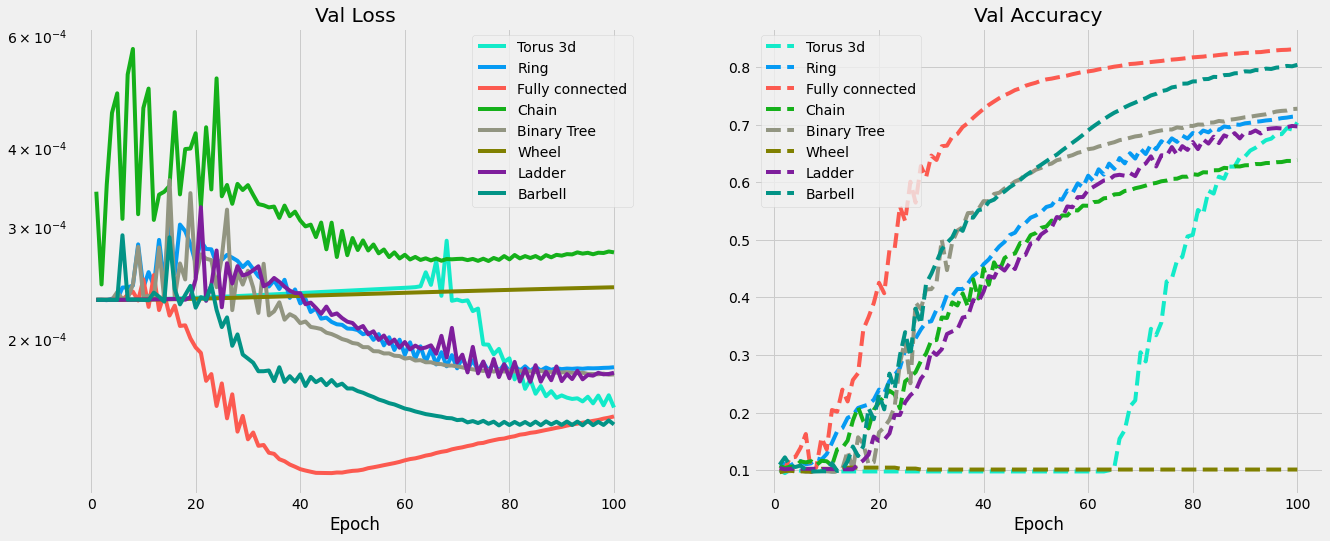

In [ ]:
## define plots
fig,ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set_title('Val Loss')
ax[1].set_title('Val Accuracy')

for c, name, topology in zip(colors, T, topologies):
    print('Decentralized learning with {} Topology'.format(name))
    ax[0].plot(valState[name].groupby('Epoch').mean()['loss'], label=name, color=c)
    ax[0].set_yscale('log')
    ax[1].plot(valState[name].groupby('Epoch').mean()['acc'], linestyle='dashed', label=name, color=c)


for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

**Ten runs**

Decentralized learning with Torus 3d Topology
Run 0!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.7302
Run 1!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6480
Run 2!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.7140
Run 3!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.8515
Run 4!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.6721
Run 5!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.7958
Run 6!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.8005
Run 7!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.6810
Run 8!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.7966
Run 9!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.6811
Test accuracy of Torus 3d Topology after 10 runs: mean 0.7371  std 0.0656 

Decentralized learning with Ring Topology
Run 0!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.5233
Run 1!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.6669
Run 2!


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Test accuracy: 0.5198
Run 3!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.7563
Run 4!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.6732
Run 5!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.7149
Run 6!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.6400
Run 7!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.6147
Run 8!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.8130
Run 9!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.6234
Test accuracy of Ring Topology after 10 runs: mean 0.6546  std 0.0882 

Decentralized learning with Fully connected Topology
Run 0!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.8118
Run 1!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.7759
Run 2!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.7713
Run 3!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.9012
Run 4!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.8850
Run 5!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.8366
Run 6!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.9049
Run 7!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.7946
Run 8!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.9075
Run 9!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.2406
Test accuracy of Fully connected Topology after 10 runs: mean 0.7829  std 0.1879 

Decentralized learning with Chain Topology
Run 0!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.4262
Run 1!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.6755
Run 2!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.5656
Run 3!


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


Test accuracy: 0.7324
Run 4!


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


Test accuracy: 0.5626
Run 5!


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Test accuracy: 0.6994
Run 6!


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Test accuracy: 0.6905
Run 7!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.5942
Run 8!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.7402
Run 9!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.5788
Test accuracy of Chain Topology after 10 runs: mean 0.6265  std 0.0934 

Decentralized learning with Binary Tree Topology
Run 0!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.6526
Run 1!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6561
Run 2!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.6168
Run 3!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.6867
Run 4!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6731
Run 5!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.7219
Run 6!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.8112
Run 7!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.7089
Run 8!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.8608
Run 9!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.7810
Test accuracy of Binary Tree Topology after 10 runs: mean 0.7169  std 0.0738 

Decentralized learning with Wheel Topology
Run 0!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6526
Run 1!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.7204
Run 2!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6501
Run 3!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.9008
Run 4!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.7701
Run 5!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.8253
Run 6!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.7720
Run 7!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.7570
Run 8!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.6826
Run 9!


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Test accuracy: 0.1086
Test accuracy of Wheel Topology after 10 runs: mean 0.6840  std 0.2054 

Decentralized learning with Ladder Topology
Run 0!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.5503
Run 1!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.6265
Run 2!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.6781
Run 3!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.8442
Run 4!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.7914
Run 5!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.7324
Run 6!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6881
Run 7!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.6663
Run 8!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.7970
Run 9!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.5443
Test accuracy of Ladder Topology after 10 runs: mean 0.6919  std 0.0963 

Decentralized learning with Barbell Topology
Run 0!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6349
Run 1!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6910
Run 2!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6982
Run 3!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.7851
Run 4!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.6425
Run 5!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.7755
Run 6!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.8218
Run 7!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.6484
Run 8!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.8396
Run 9!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.7489
Test accuracy of Barbell Topology after 10 runs: mean 0.7286  std 0.0720 



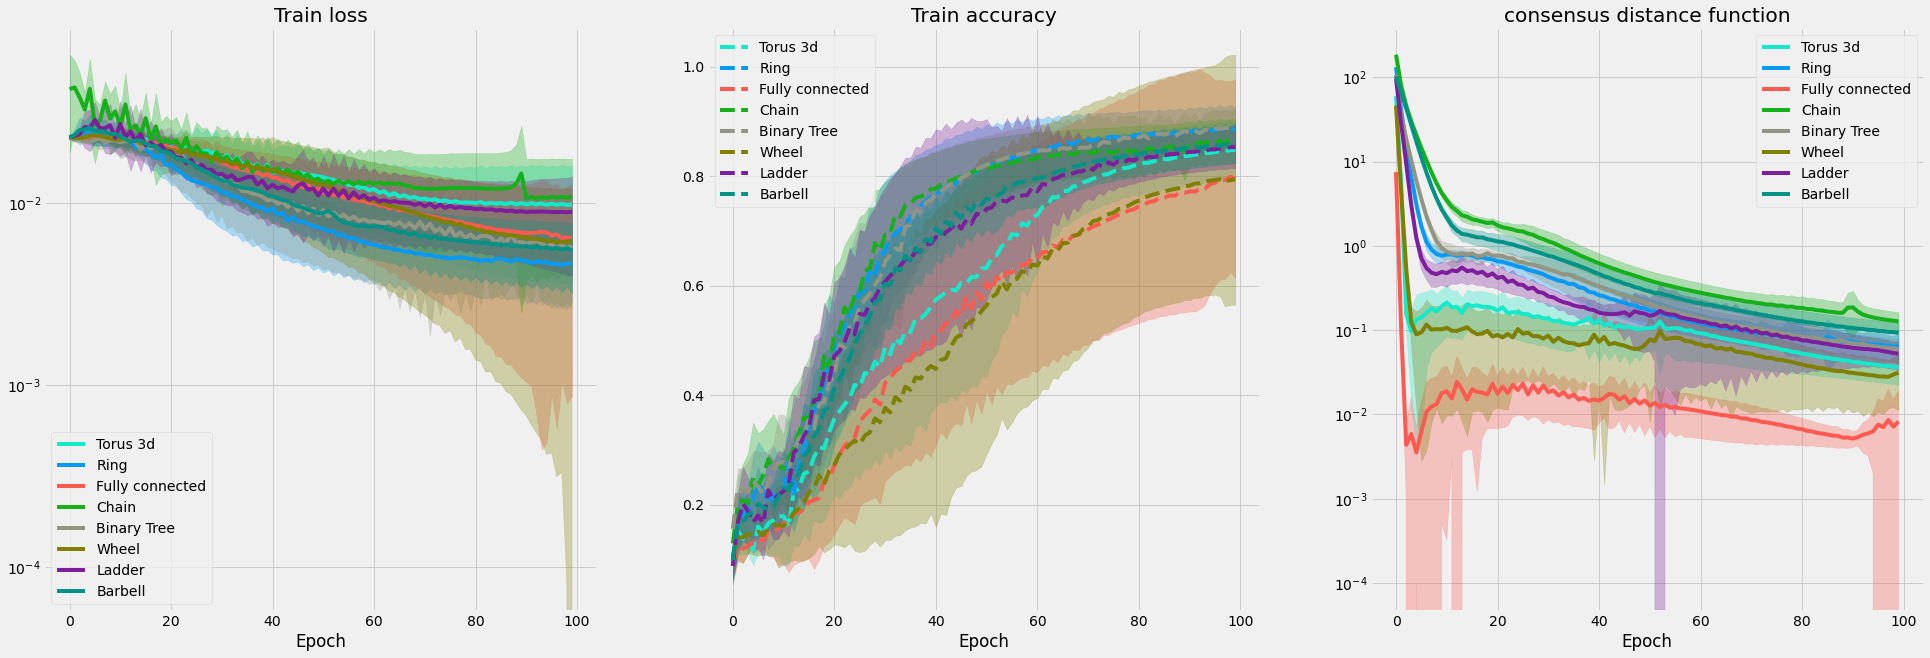

In [ ]:
## Number of epochs
maxEpoch = 100

## Number of nodes
K = 8

## Total number of runs
totalRuns = 10

## define plots
fig,ax = plt.subplots(1,3, figsize=(30,10))
ax[0].set_title('Train loss')
ax[1].set_title('Train accuracy')
ax[2].set_title('consensus distance function')

T = ['Torus 3d', 'Ring', 'Fully connected', 'Chain', 'Binary Tree', 'Wheel', 'Ladder', 'Barbell']
topologies = [TorusTopology, ringTopology, FullConnectedTopology, ChainTopology, BinaryTreeTopology, WheelTopology, LadderTopology, BarbellTopology]
states = {t:None for t in T}

for c, name, topology in zip(colors, T, topologies):
    losses = []
    testaccList = []
    acc = []
    valloss = []
    valacc = []
    cDistsList = []
    print('Decentralized learning with {} Topology'.format(name))
    for run in range(totalRuns):
        # set random seed
        torch.manual_seed(run)
        torch.cuda.manual_seed(run) # set random seed of cuda
        torch.cuda.manual_seed_all(run) # set random seed of multi-GPU
        np.random.seed(run)

        # create non-iid data
        K = 8 # number of nodes
        nodesNoneIIDData = []
        batchSize = 100
        indexIID = mnist_noniid(trainset, trainL, K)

        for i in range(K):
            tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
            tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
            nodesNoneIIDData.append((tmpX,tmpy))

        print('Run {}!'.format(run))

        if name == 'Social Net':
            t = topology()
            resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=maxEpoch, validation=nodesValidation)
        elif 'Torus' in name:
            t = topology(K, dimension=name.split()[-1])
            resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=100, validation=nodesValidation) 
        else:
            t = topology(K)
            resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=maxEpoch, validation=nodesValidation)
        losses.append(resultdf.groupby('Epoch').mean()['loss'])
        acc.append(resultdf.groupby('Epoch').mean()['acc'])
        cDistsList.append(cDists)

        valloss.append(resultVal.groupby('Epoch').mean()['loss'])
        valacc.append(resultVal.groupby('Epoch').mean()['acc'])
        
        resultdfTest = test(nodesTest, t, models, device)
        testacc = resultdfTest['acc'].mean()
        testaccList.append(testacc)
        print('Test accuracy: {:.4f}'.format(testacc))

    losses, acc, testaccList, cDistsList = np.array(losses), np.array(acc), np.array(testaccList), np.array(cDistsList)     
    states[name] = {'trainloss': losses, 'trainacc': acc, 'testacc': testaccList, 'valloss': np.array(valloss), 'valacc': np.array(valacc)}
    ## calclate the mean and variance
    ax[0].plot(losses.mean(axis=0), label=name, color=c)
    ax[0].fill_between(np.arange(maxEpoch), losses.mean(axis=0) - np.std(losses, axis=0), losses.mean(axis=0) + np.std(losses, axis=0), alpha=0.3, color=c)
    ax[0].set_yscale('log')

    ax[1].plot(acc.mean(axis=0), linestyle='dashed', label=name, color=c)
    ax[1].fill_between(np.arange(maxEpoch), acc.mean(axis=0) - np.std(acc, axis=0), acc.mean(axis=0) + np.std(acc, axis=0), alpha=0.3, color=c)

    ax[2].plot(cDistsList.mean(axis=0), label=name, color=c)
    ax[2].fill_between(np.arange(maxEpoch), cDistsList.mean(axis=0) - np.std(cDistsList, axis=0), cDistsList.mean(axis=0) + np.std(cDistsList, axis=0), alpha=0.3, color=c)
    ax[2].set_yscale('log')

    print('Test accuracy of {} Topology after 10 runs: mean {:.4f}  std {:.4f} \n'.format(name, testaccList.mean(), np.std(testaccList, axis=0)))

for i in range(3):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

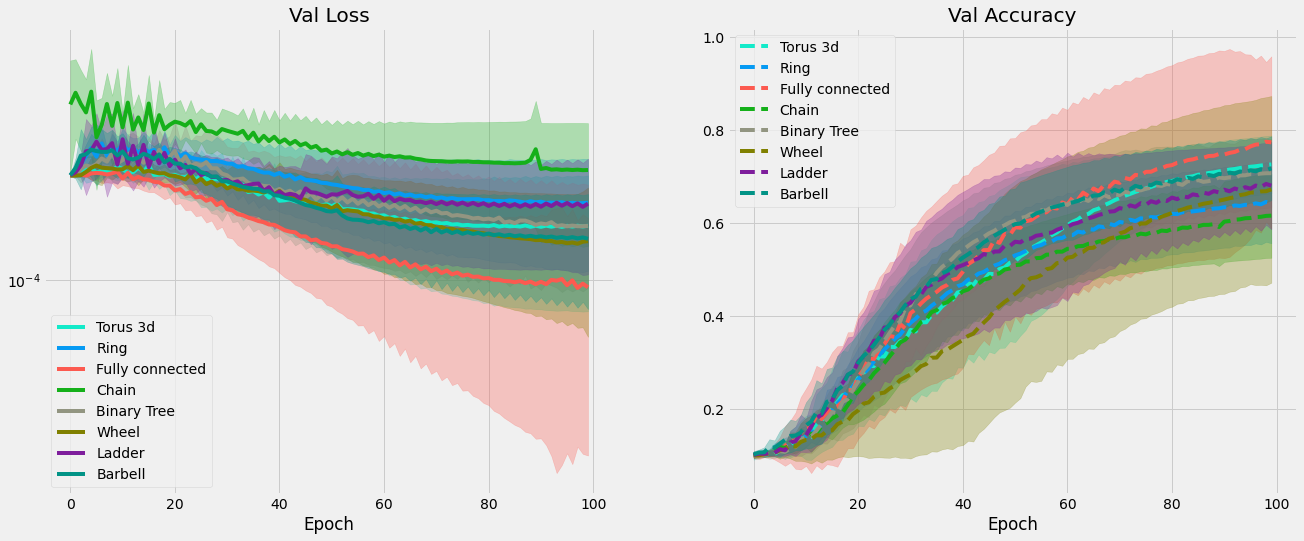

In [ ]:
## define plots
fig,ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set_title('Val Loss')
ax[1].set_title('Val Accuracy')

for c, name, topology in zip(colors, T, topologies):
    losses, acc = states[name]['valloss'], states[name]['valacc']
    ## calclate the mean and variance
    ax[0].plot(losses.mean(axis=0), label=name, color=c)
    ax[0].fill_between(np.arange(maxEpoch), losses.mean(axis=0) - np.std(losses, axis=0), losses.mean(axis=0) + np.std(losses, axis=0), alpha=0.3, color=c)
    ax[0].set_yscale('log')

    ax[1].plot(acc.mean(axis=0), linestyle='dashed', label=name, color=c)
    ax[1].fill_between(np.arange(maxEpoch), acc.mean(axis=0) - np.std(acc, axis=0), acc.mean(axis=0) + np.std(acc, axis=0), alpha=0.3, color=c)

for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

**Save results**

In [ ]:
with open(join(result_path, 'non_iid_two_labels_ten_runs.pkl'),'wb') as f:
    pickle.dump(states, f)

### One label

In [ ]:
K = 8 # number of nodes
nodesNoneIIDData = []
batchSize = 100

np.random.seed(10)
indexIID = mnist_noniid(trainset, trainL, K, num_shards=10, num_imgs=4000, label_skew=1)

for i in range(K):
    tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
    tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
    nodesNoneIIDData.append((tmpX,tmpy))


print(nodesNoneIIDData[0][0].shape)
print(nodesNoneIIDData[0][1].shape)

torch.Size([40, 100, 1, 28, 28])
torch.Size([40, 100])


(array([   0.,    0.,    0.,    0.,    0., 4000.,    0.,    0.,    0.,
           0.]),
 array([6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5]),
 <a list of 10 Patch objects>)

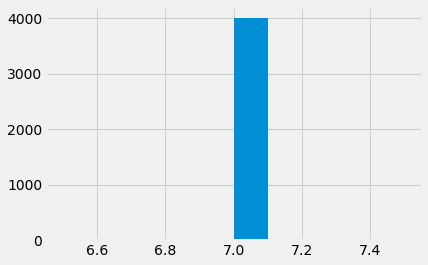

In [ ]:
plt.hist(nodesNoneIIDData[3][1].flatten())

**One run**

Decentralized learning with Torus 3d Topology


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy of Torus 3d Topology: 0.5297
Decentralized learning with Ring Topology


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy of Ring Topology: 0.3432
Decentralized learning with Fully connected Topology


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy of Fully connected Topology: 0.6113
Decentralized learning with Chain Topology


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy of Chain Topology: 0.3840
Decentralized learning with Binary Tree Topology


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy of Binary Tree Topology: 0.4714
Decentralized learning with Wheel Topology


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy of Wheel Topology: 0.4481
Decentralized learning with Ladder Topology


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy of Ladder Topology: 0.4653
Decentralized learning with Barbell Topology


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy of Barbell Topology: 0.4369


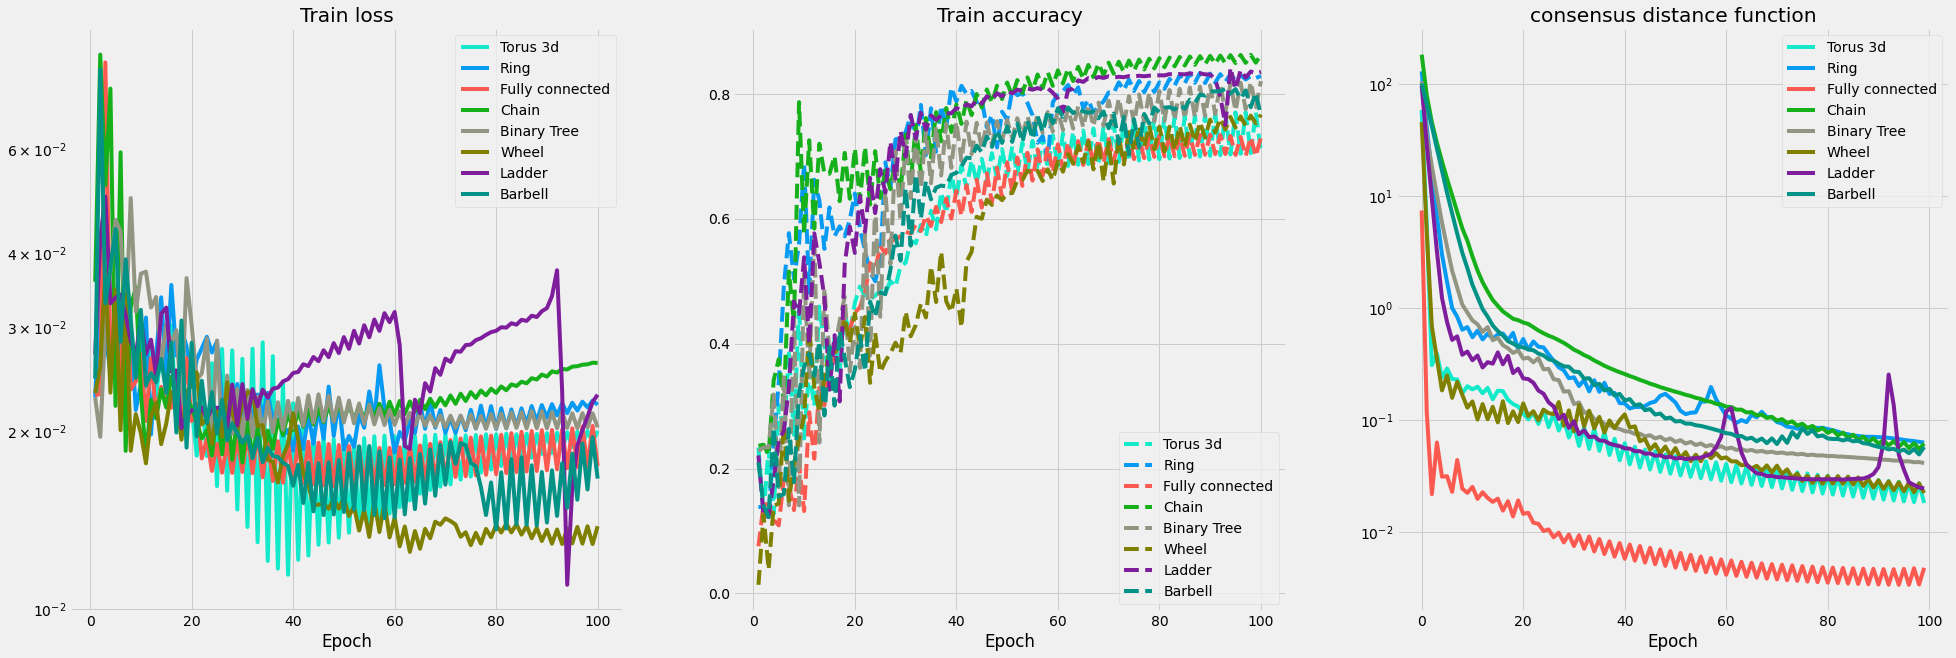

In [ ]:
## Number of nodes
K = 8

## define plots
fig,ax = plt.subplots(1,3, figsize=(30,10))
ax[0].set_title('Train loss')
ax[1].set_title('Train accuracy')
ax[2].set_title('consensus distance function')

T = ['Torus 3d', 'Ring', 'Fully connected', 'Chain', 'Binary Tree', 'Wheel', 'Ladder', 'Barbell']
topologies = [TorusTopology, ringTopology, FullConnectedTopology, ChainTopology, BinaryTreeTopology, WheelTopology, LadderTopology, BarbellTopology]
valState = {t:None for t in T}

for c, name, topology in zip(colors, T, topologies):
    print('Decentralized learning with {} Topology'.format(name))
    if name == 'Social Net':
        t = topology()
        resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=100, validation=nodesValidation)
    elif 'Torus' in name:
        t = topology(K, dimension=name.split()[-1])
        resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=100, validation=nodesValidation)
    else:
        t = topology(K)
        resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=100, validation=nodesValidation)
    
    ax[0].plot(resultdf.groupby('Epoch').mean()['loss'], label=name, color=c)
    ax[0].set_yscale('log')
    ax[1].plot(resultdf.groupby('Epoch').mean()['acc'], linestyle='dashed', label=name, color=c)
    ax[2].plot(cDists, label=name, color=c)
    ax[2].set_yscale('log')
    valState[name] = resultVal

    resultdfTest = test(nodesTest, t, models, device)
    testacc = resultdfTest['acc'].mean()
    print('Test accuracy of {} Topology: {:.4f}'.format(name, testacc))

for i in range(3):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

Decentralized learning with Torus 3d Topology
Decentralized learning with Ring Topology
Decentralized learning with Fully connected Topology
Decentralized learning with Chain Topology
Decentralized learning with Binary Tree Topology
Decentralized learning with Wheel Topology
Decentralized learning with Ladder Topology
Decentralized learning with Barbell Topology


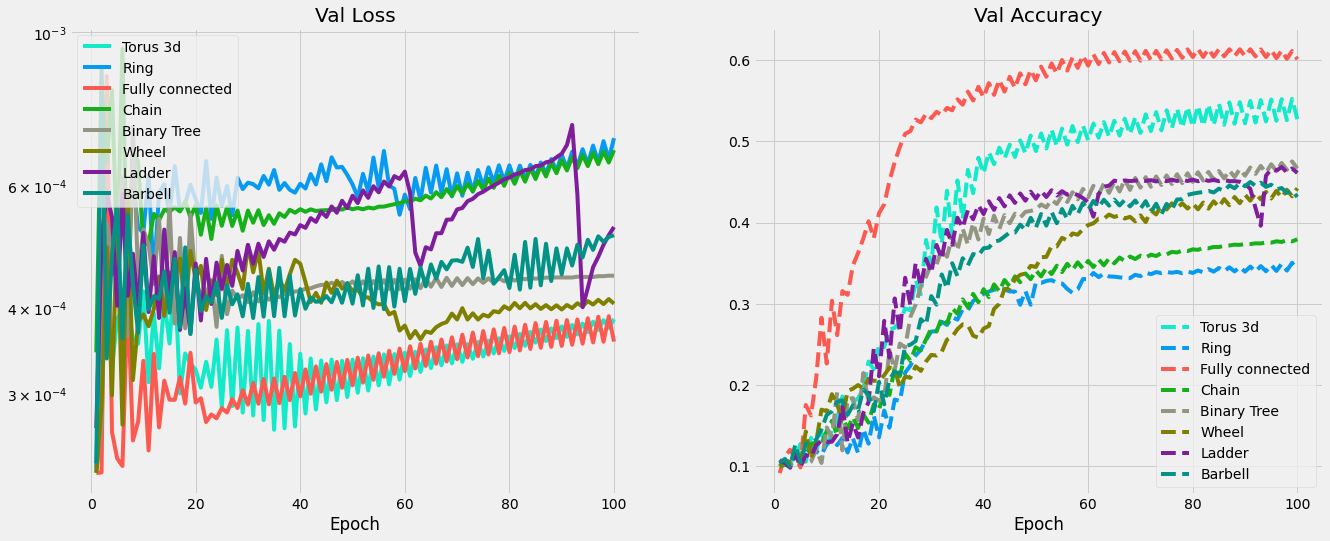

In [ ]:
## define plots
fig,ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set_title('Val Loss')
ax[1].set_title('Val Accuracy')

for c, name, topology in zip(colors, T, topologies):
    print('Decentralized learning with {} Topology'.format(name))
    ax[0].plot(valState[name].groupby('Epoch').mean()['loss'], label=name, color=c)
    ax[0].set_yscale('log')
    ax[1].plot(valState[name].groupby('Epoch').mean()['acc'], linestyle='dashed', label=name, color=c)


for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

**Ten runs**

Decentralized learning with Torus 3d Topology
Run 0!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.5756
Run 1!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.5597
Run 2!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.5068
Run 3!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.5514
Run 4!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.5125
Run 5!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.5153
Run 6!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.5724
Run 7!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.5236
Run 8!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.5117
Run 9!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.5035
Test accuracy of Torus 3d Topology after 10 runs: mean 0.5333  std 0.0269 

Decentralized learning with Ring Topology
Run 0!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.3818
Run 1!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.3679
Run 2!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.3836
Run 3!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.3603
Run 4!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.3669
Run 5!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.3585
Run 6!


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Test accuracy: 0.3788
Run 7!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.3593
Run 8!


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Test accuracy: 0.3761
Run 9!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.3465
Test accuracy of Ring Topology after 10 runs: mean 0.3680  std 0.0114 

Decentralized learning with Fully connected Topology
Run 0!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.6426
Run 1!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.6318
Run 2!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.6124
Run 3!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.6326
Run 4!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.5961
Run 5!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.6334
Run 6!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.6457
Run 7!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.6458
Run 8!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.6168
Run 9!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.5988
Test accuracy of Fully connected Topology after 10 runs: mean 0.6256  std 0.0176 

Decentralized learning with Chain Topology
Run 0!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.3941
Run 1!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.3510
Run 2!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.3565
Run 3!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.3974
Run 4!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.3751
Run 5!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.3544
Run 6!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.3750
Run 7!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.3817
Run 8!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.4002
Run 9!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.3802
Test accuracy of Chain Topology after 10 runs: mean 0.3766  std 0.0170 

Decentralized learning with Binary Tree Topology
Run 0!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.5004
Run 1!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.4752
Run 2!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.4503
Run 3!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.5052
Run 4!


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Test accuracy: 0.4644
Run 5!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.4465
Run 6!


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Test accuracy: 0.4860
Run 7!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.4780
Run 8!


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Test accuracy: 0.4397
Run 9!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.4248
Test accuracy of Binary Tree Topology after 10 runs: mean 0.4670  std 0.0252 

Decentralized learning with Wheel Topology
Run 0!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.4830
Run 1!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.4505
Run 2!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.4446
Run 3!


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Test accuracy: 0.4687
Run 4!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.4664
Run 5!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.4410
Run 6!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.5054
Run 7!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.4583
Run 8!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.4487
Run 9!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.4426
Test accuracy of Wheel Topology after 10 runs: mean 0.4609  std 0.0195 

Decentralized learning with Ladder Topology
Run 0!


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Test accuracy: 0.4534
Run 1!


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Test accuracy: 0.4616
Run 2!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.4560
Run 3!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.4685
Run 4!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.4362
Run 5!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.4560
Run 6!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.4734
Run 7!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.3910
Run 8!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.4631
Run 9!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.4338
Test accuracy of Ladder Topology after 10 runs: mean 0.4493  std 0.0228 

Decentralized learning with Barbell Topology
Run 0!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.4714
Run 1!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.4370
Run 2!


100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


Test accuracy: 0.4128
Run 3!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.4651
Run 4!


100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


Test accuracy: 0.4223
Run 5!


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


Test accuracy: 0.4461
Run 6!


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


Test accuracy: 0.4573
Run 7!


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Test accuracy: 0.4378
Run 8!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.4303
Run 9!


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


Test accuracy: 0.3877
Test accuracy of Barbell Topology after 10 runs: mean 0.4368  std 0.0240 



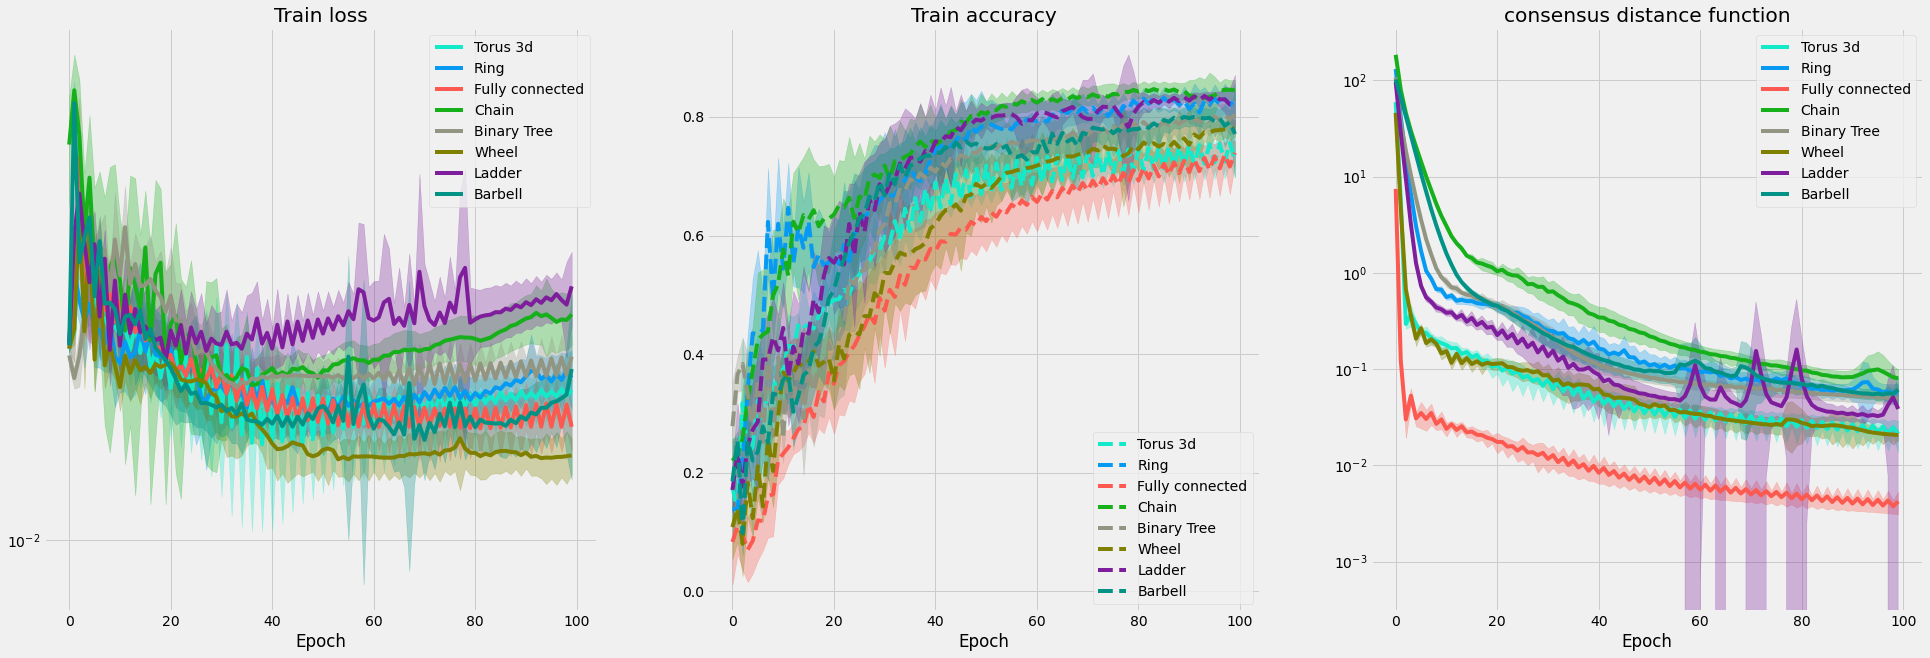

In [ ]:
## Number of epochs
maxEpoch = 100

## Number of nodes
K = 8

## Total number of runs
totalRuns = 10

## define plots
fig,ax = plt.subplots(1,3, figsize=(30,10))
ax[0].set_title('Train loss')
ax[1].set_title('Train accuracy')
ax[2].set_title('consensus distance function')

T = ['Torus 3d', 'Ring', 'Fully connected', 'Chain', 'Binary Tree', 'Wheel', 'Ladder', 'Barbell']
topologies = [TorusTopology, ringTopology, FullConnectedTopology, ChainTopology, BinaryTreeTopology, WheelTopology, LadderTopology, BarbellTopology]
states = {t:None for t in T}

for c, name, topology in zip(colors, T, topologies):
    losses = []
    testaccList = []
    acc = []
    valloss = []
    valacc = []
    cDistsList = []
    print('Decentralized learning with {} Topology'.format(name))
    for run in range(totalRuns):
        # set random seed
        torch.manual_seed(run)
        torch.cuda.manual_seed(run) # set random seed of cuda
        torch.cuda.manual_seed_all(run) # set random seed of multi-GPU
        np.random.seed(run)

        # create non-iid data
        K = 8 # number of nodes
        nodesNoneIIDData = []
        batchSize = 100

        np.random.seed(10)
        indexIID = mnist_noniid(trainset, trainL, K, num_shards=10, num_imgs=4000, label_skew=1)

        for i in range(K):
            tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
            tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
            nodesNoneIIDData.append((tmpX,tmpy))

        print('Run {}!'.format(run))

        if name == 'Social Net':
            t = topology()
            resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=maxEpoch, validation=nodesValidation)
        elif 'Torus' in name:
            t = topology(K, dimension=name.split()[-1])
            resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=100, validation=nodesValidation)
        else:
            t = topology(K)
            resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=maxEpoch, validation=nodesValidation)
        losses.append(resultdf.groupby('Epoch').mean()['loss'])
        acc.append(resultdf.groupby('Epoch').mean()['acc'])
        cDistsList.append(cDists)

        valloss.append(resultVal.groupby('Epoch').mean()['loss'])
        valacc.append(resultVal.groupby('Epoch').mean()['acc'])
        
        resultdfTest = test(nodesTest, t, models, device)
        testacc = resultdfTest['acc'].mean()
        testaccList.append(testacc)
        print('Test accuracy: {:.4f}'.format(testacc))
    
    losses, acc, testaccList, cDistsList = np.array(losses), np.array(acc), np.array(testaccList), np.array(cDistsList)
    states[name] = {'trainloss': losses, 'trainacc': acc, 'testacc': testaccList, 'valloss': np.array(valloss), 'valacc': np.array(valacc)}
    ## calclate the mean and variance
    ax[0].plot(losses.mean(axis=0), label=name, color=c)
    ax[0].fill_between(np.arange(maxEpoch), losses.mean(axis=0) - np.std(losses, axis=0), losses.mean(axis=0) + np.std(losses, axis=0), alpha=0.3, color=c)
    ax[0].set_yscale('log')

    ax[1].plot(acc.mean(axis=0), linestyle='dashed', label=name, color=c)
    ax[1].fill_between(np.arange(maxEpoch), acc.mean(axis=0) - np.std(acc, axis=0), acc.mean(axis=0) + np.std(acc, axis=0), alpha=0.3, color=c)

    ax[2].plot(cDistsList.mean(axis=0), label=name, color=c)
    ax[2].fill_between(np.arange(maxEpoch), cDistsList.mean(axis=0) - np.std(cDistsList, axis=0), cDistsList.mean(axis=0) + np.std(cDistsList, axis=0), alpha=0.3, color=c)
    ax[2].set_yscale('log')

    print('Test accuracy of {} Topology after 10 runs: mean {:.4f}  std {:.4f} \n'.format(name, testaccList.mean(), np.std(testaccList, axis=0)))

for i in range(3):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

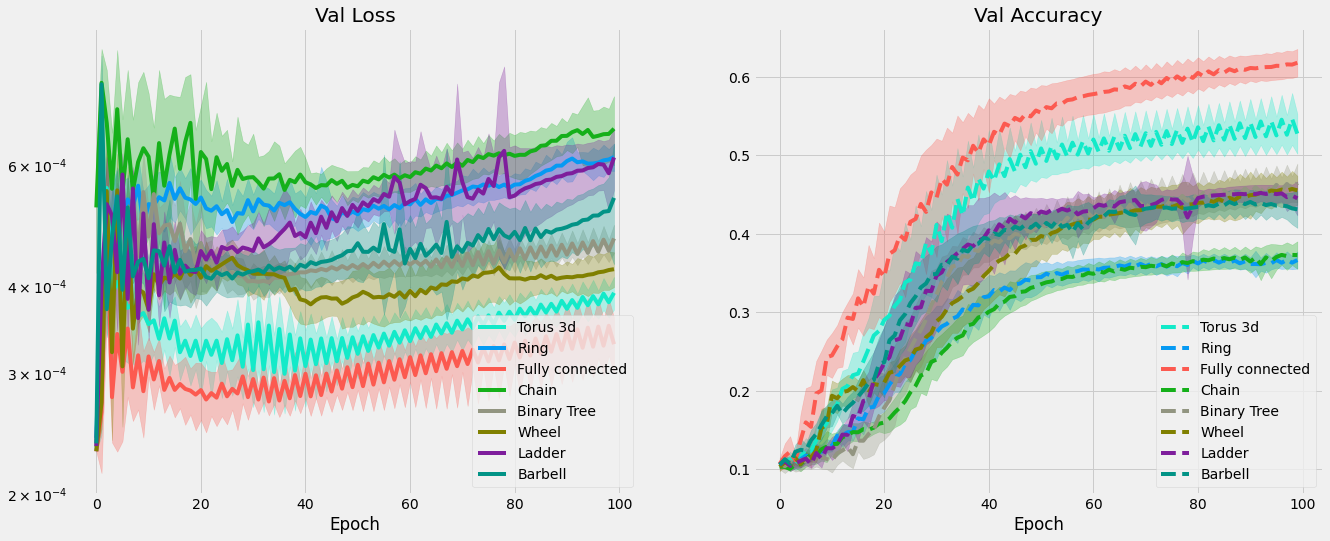

In [ ]:
## define plots
fig,ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set_title('Val Loss')
ax[1].set_title('Val Accuracy')

for c, name, topology in zip(colors, T, topologies):
    losses, acc = states[name]['valloss'], states[name]['valacc']
    ## calclate the mean and variance
    ax[0].plot(losses.mean(axis=0), label=name, color=c)
    ax[0].fill_between(np.arange(maxEpoch), losses.mean(axis=0) - np.std(losses, axis=0), losses.mean(axis=0) + np.std(losses, axis=0), alpha=0.3, color=c)
    ax[0].set_yscale('log')

    ax[1].plot(acc.mean(axis=0), linestyle='dashed', label=name, color=c)
    ax[1].fill_between(np.arange(maxEpoch), acc.mean(axis=0) - np.std(acc, axis=0), acc.mean(axis=0) + np.std(acc, axis=0), alpha=0.3, color=c)

for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

**Save results**

In [ ]:
with open(join(result_path, 'non_iid_one_label_ten_runs.pkl'),'wb') as f:
    pickle.dump(states, f)

### Random seed 3 for fully connected

Experiments of fully connected topology on fixed non-iid data. We compare it with the topology found by iterative algorithm in the report.

Decentralized learning with Fully connected Topology
Run 0!


100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


Test accuracy: 0.8406
Run 1!


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Test accuracy: 0.8919
Run 2!


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Test accuracy: 0.8916
Run 3!


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Test accuracy: 0.9028
Run 4!


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Test accuracy: 0.8087
Run 5!


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Test accuracy: 0.9220
Run 6!


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Test accuracy: 0.9195
Run 7!


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Test accuracy: 0.9000
Run 8!


100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


Test accuracy: 0.9266
Run 9!


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


Test accuracy: 0.8920
Test accuracy of Fully connected Topology after 10 runs: mean 0.8896  std 0.0354 



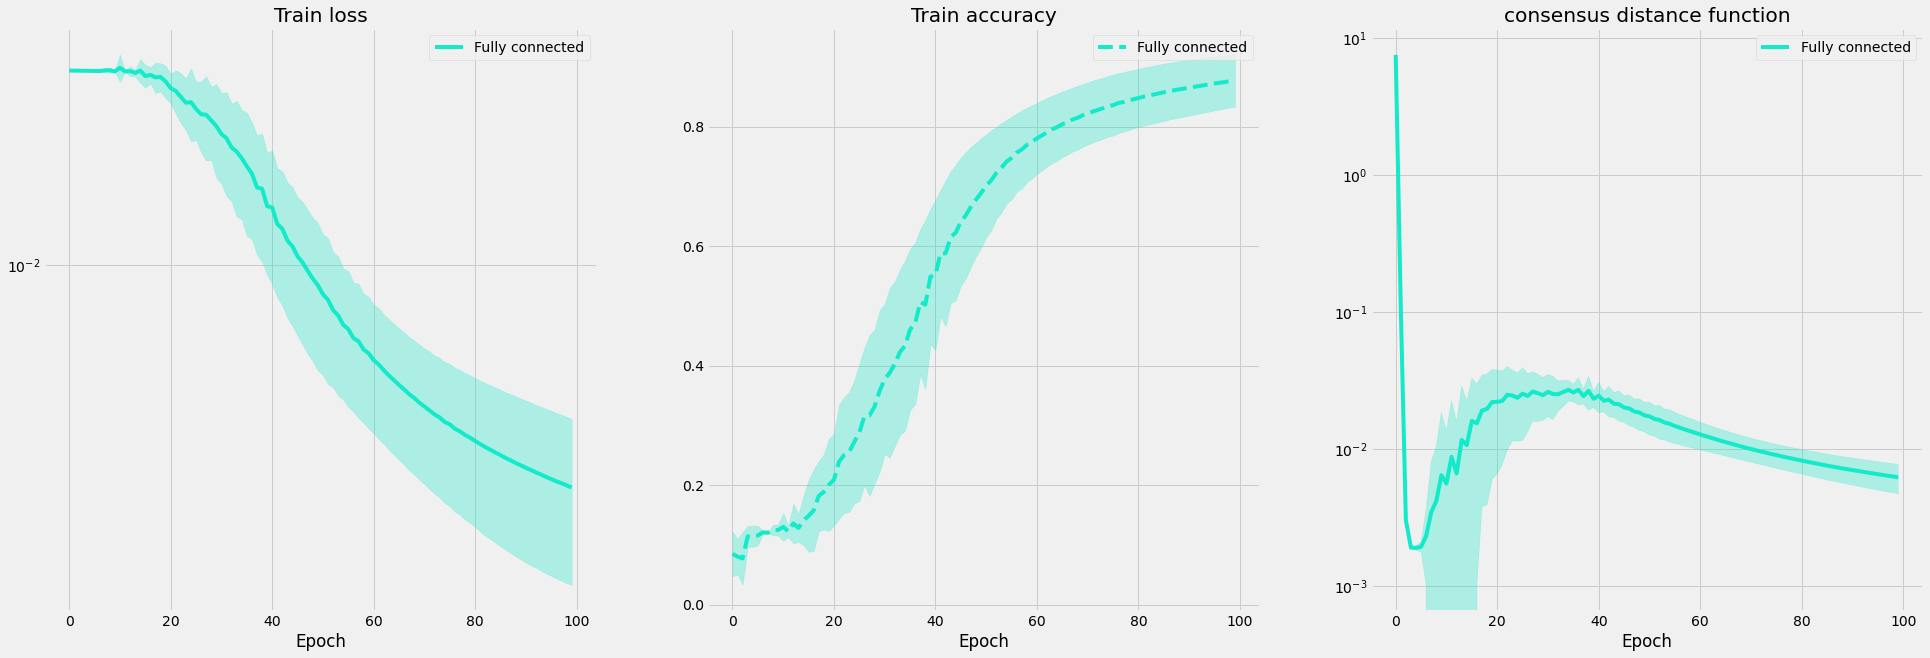

In [ ]:
## Number of epochs
maxEpoch = 100

## Number of nodes
K = 8

## Total number of runs
totalRuns = 10

## define plots
fig,ax = plt.subplots(1,3, figsize=(30,10))
ax[0].set_title('Train loss')
ax[1].set_title('Train accuracy')
ax[2].set_title('consensus distance function')

T = ['Fully connected']
topologies = [FullConnectedTopology]
states = {t:None for t in T}

for c, name, topology in zip(colors, T, topologies):
    losses = []
    testaccList = []
    acc = []
    valloss = []
    valacc = []
    cDistsList = []
    print('Decentralized learning with {} Topology'.format(name))
    for run in range(totalRuns):
        # set random seed
        torch.manual_seed(run)
        torch.cuda.manual_seed(run) # set random seed of cuda
        torch.cuda.manual_seed_all(run) # set random seed of multi-GPU
        np.random.seed(3)

        # create non-iid data
        K = 8 # number of nodes
        nodesNoneIIDData = []
        batchSize = 100
        indexIID = mnist_noniid(trainset, trainL, K)

        for i in range(K):
            tmpX = mnist[indexIID[i]].reshape(-1, batchSize, 1, 28,28)
            tmpy = mnistL[indexIID[i]].reshape(-1, batchSize)
            nodesNoneIIDData.append((tmpX,tmpy))

        print('Run {}!'.format(run))

        if name == 'Social Net':
            t = topology()
            resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=maxEpoch, validation=nodesValidation)
        elif 'Torus' in name:
            t = topology(K, dimension=name.split()[-1])
            resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=100, validation=nodesValidation) 
        else:
            t = topology(K)
            resultdf, resultVal, cDists, models = computeDecentralize(nodesNoneIIDData, t, K, device, max_epoch=maxEpoch, validation=nodesValidation)
        losses.append(resultdf.groupby('Epoch').mean()['loss'])
        acc.append(resultdf.groupby('Epoch').mean()['acc'])
        cDistsList.append(cDists)

        valloss.append(resultVal.groupby('Epoch').mean()['loss'])
        valacc.append(resultVal.groupby('Epoch').mean()['acc'])
        
        resultdfTest = test(nodesTest, t, models, device)
        testacc = resultdfTest['acc'].mean()
        testaccList.append(testacc)
        print('Test accuracy: {:.4f}'.format(testacc))

    losses, acc, testaccList, cDistsList = np.array(losses), np.array(acc), np.array(testaccList), np.array(cDistsList)     
    states[name] = {'trainloss': losses, 'trainacc': acc, 'testacc': testaccList, 'valloss': np.array(valloss), 'valacc': np.array(valacc)}
    ## calclate the mean and variance
    ax[0].plot(losses.mean(axis=0), label=name, color=c)
    ax[0].fill_between(np.arange(maxEpoch), losses.mean(axis=0) - np.std(losses, axis=0), losses.mean(axis=0) + np.std(losses, axis=0), alpha=0.3, color=c)
    ax[0].set_yscale('log')

    ax[1].plot(acc.mean(axis=0), linestyle='dashed', label=name, color=c)
    ax[1].fill_between(np.arange(maxEpoch), acc.mean(axis=0) - np.std(acc, axis=0), acc.mean(axis=0) + np.std(acc, axis=0), alpha=0.3, color=c)

    ax[2].plot(cDistsList.mean(axis=0), label=name, color=c)
    ax[2].fill_between(np.arange(maxEpoch), cDistsList.mean(axis=0) - np.std(cDistsList, axis=0), cDistsList.mean(axis=0) + np.std(cDistsList, axis=0), alpha=0.3, color=c)
    ax[2].set_yscale('log')

    print('Test accuracy of {} Topology after 10 runs: mean {:.4f}  std {:.4f} \n'.format(name, testaccList.mean(), np.std(testaccList, axis=0)))

for i in range(3):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

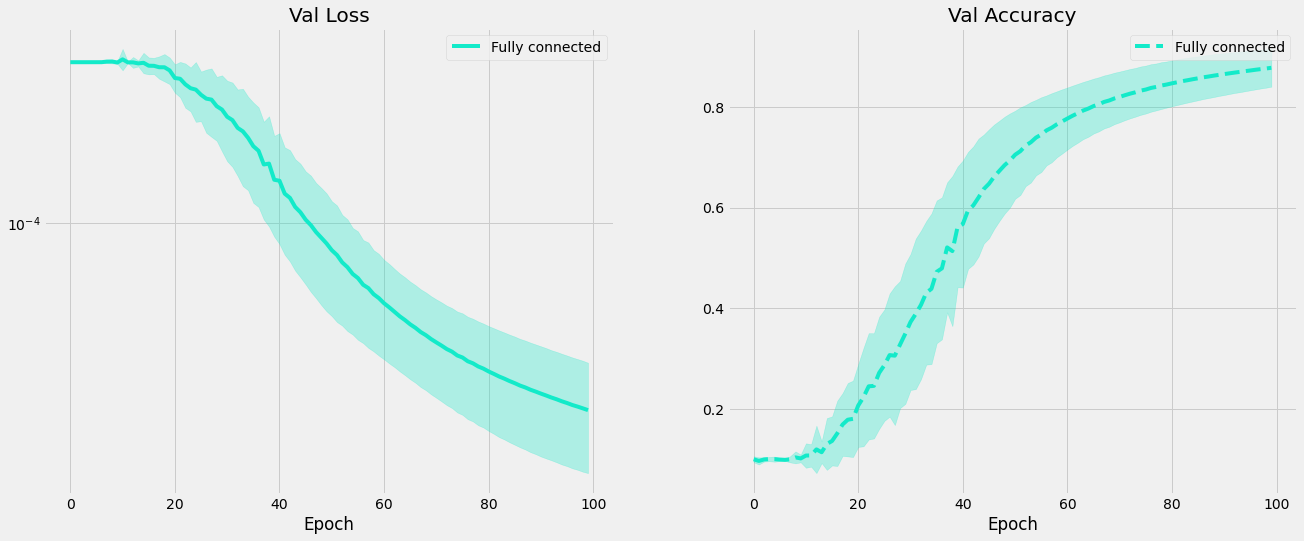

In [ ]:
## define plots
fig,ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set_title('Val Loss')
ax[1].set_title('Val Accuracy')

for c, name, topology in zip(colors, T, topologies):
    losses, acc = states[name]['valloss'], states[name]['valacc']
    ## calclate the mean and variance
    ax[0].plot(losses.mean(axis=0), label=name, color=c)
    ax[0].fill_between(np.arange(maxEpoch), losses.mean(axis=0) - np.std(losses, axis=0), losses.mean(axis=0) + np.std(losses, axis=0), alpha=0.3, color=c)
    ax[0].set_yscale('log')

    ax[1].plot(acc.mean(axis=0), linestyle='dashed', label=name, color=c)
    ax[1].fill_between(np.arange(maxEpoch), acc.mean(axis=0) - np.std(acc, axis=0), acc.mean(axis=0) + np.std(acc, axis=0), alpha=0.3, color=c)

for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

**Save the results of fully connected topology on a fixed distribution**

In [ ]:
with open(join(result_path, 'non_iid_fix_distribution_full_connected_ten_runs.pkl'),'wb') as f:
    pickle.dump(states, f)